In [1]:
import numpy as np
import pandas as pd
import pysindy as ps

from pathlib import Path
import os, sys
try:
    __file__
except NameError:
    __file__ = str(Path(os.getcwd())/'notebook.ipynb')  # Convert Path to string
base_dir = os.path.dirname(os.path.abspath(__file__))
sys.path.append(base_dir)

# https://pysindy.readthedocs.io/en/latest/api/pysindy.html
# https://pysindy.readthedocs.io/en/latest/examples/index.html

In [2]:
"""load data"""

data_folder_path = os.path.abspath(os.path.join(base_dir, ".."))+os.sep+'Data'
x_pd = pd.read_csv(data_folder_path+os.sep+'ieee14_fault_out.csv')

time_pd = x_pd['Time [s]'].to_numpy()
delta_pd = []
omega_pd = []
x_names = x_pd.columns
delta_idx = 0
omega_idx = 0
for name_ii in x_names:
    if 'delta' in name_ii:
        delta_pd.append(x_pd[name_ii].to_numpy())
        delta_idx += 1
    if 'omega' in name_ii:
        omega_pd.append(x_pd[name_ii].to_numpy())
        omega_idx +=1

after_idx = next(i for i in range(len(time_pd)) if time_pd[i] > 1.10)

delta = [delta_pd[ii][after_idx:-1] for ii in range(len(delta_pd))]
omega = [omega_pd[ii][after_idx:-1] for ii in range(len(omega_pd))]
time = time_pd[after_idx:-1]

# Combine omega and delta data using numpy
X = np.concatenate(((np.array(omega).T-1)*2*np.pi*60,
                    np.array(delta).T), axis=1)
n_vars_x = X.shape[1]  # (omega, delta)

# Generate random indices for training set
n_total = len(X)
train_indices = slice(0,200)
valid_indices = slice(200, n_total)
# n_train = 200
# train_indices = np.random.permutation(n_total)[:n_train]
# valid_indices = np.array([i for i in range(n_total) if i not in train_indices])
time_train = time[train_indices]

# Split data into training and validation sets
train_x = X[train_indices,:]  # Shape: (Train_Sample, features)
valid_x = X[valid_indices,:]  # Shape: (Valid_Sample, features)

Ntraj = len(delta)

In [3]:
def train_model(x, t):
    # 确保x是numpy数组
    if isinstance(x, list):
        x = np.array(x)
    
    # 确保t是numpy数组
    if isinstance(t, list):
        t = np.array(t)
    
    # custom_library = CustomLibrary(degree=2)
    polynomial_library = ps.PolynomialLibrary(degree=2)
    fourier_library = ps.FourierLibrary(n_frequencies=1)
    product_library = ps.GeneralizedLibrary([polynomial_library, fourier_library])

    model = ps.SINDy(
        optimizer=ps.STLSQ(threshold=0.1),
        feature_library=product_library,
        differentiation_method=ps.SmoothedFiniteDifference(
            smoother_kws={'window_length': 7}
        )
    )
    # 训练模型
    model.fit(x, t=t)
    
    return model

In [4]:
# 训练模型
model = train_model(train_x, time_train)

In [5]:
import matplotlib.pyplot as plt

# 评估和可视化函数
def evaluate_and_visualize(model, x, t):
    """
    评估模型性能并可视化结果
    """
    # 使用模型预测完整状态的导数
    x_dot_pred = model.predict(x)
    
    # 使用相同的数值微分方法计算实际导数作为比较
    diff_method = ps.SmoothedFiniteDifference(
        smoother_kws={'window_length': 7}
    )
    x_dot_true = diff_method._differentiate(x, t)
    
    # 比较omega部分的导数（前5个变量）
    plt.figure(figsize=(15, 10))
    for i in range(5):
        plt.subplot(2, 3, i+1)
        plt.plot(t, x_dot_true[:, i], 'b-', label=f'True d_omega_{i+1}/dt')
        plt.plot(t, x_dot_pred[:, i], 'r--', label=f'Predicted d_omega_{i+1}/dt')
        plt.xlabel('Time')
        plt.ylabel(f'd_omega_{i+1}/dt')
        plt.legend()
    plt.tight_layout()
    plt.show()
    
    # 打印方程
    print("\nDiscovered Equations:")
    model.print()

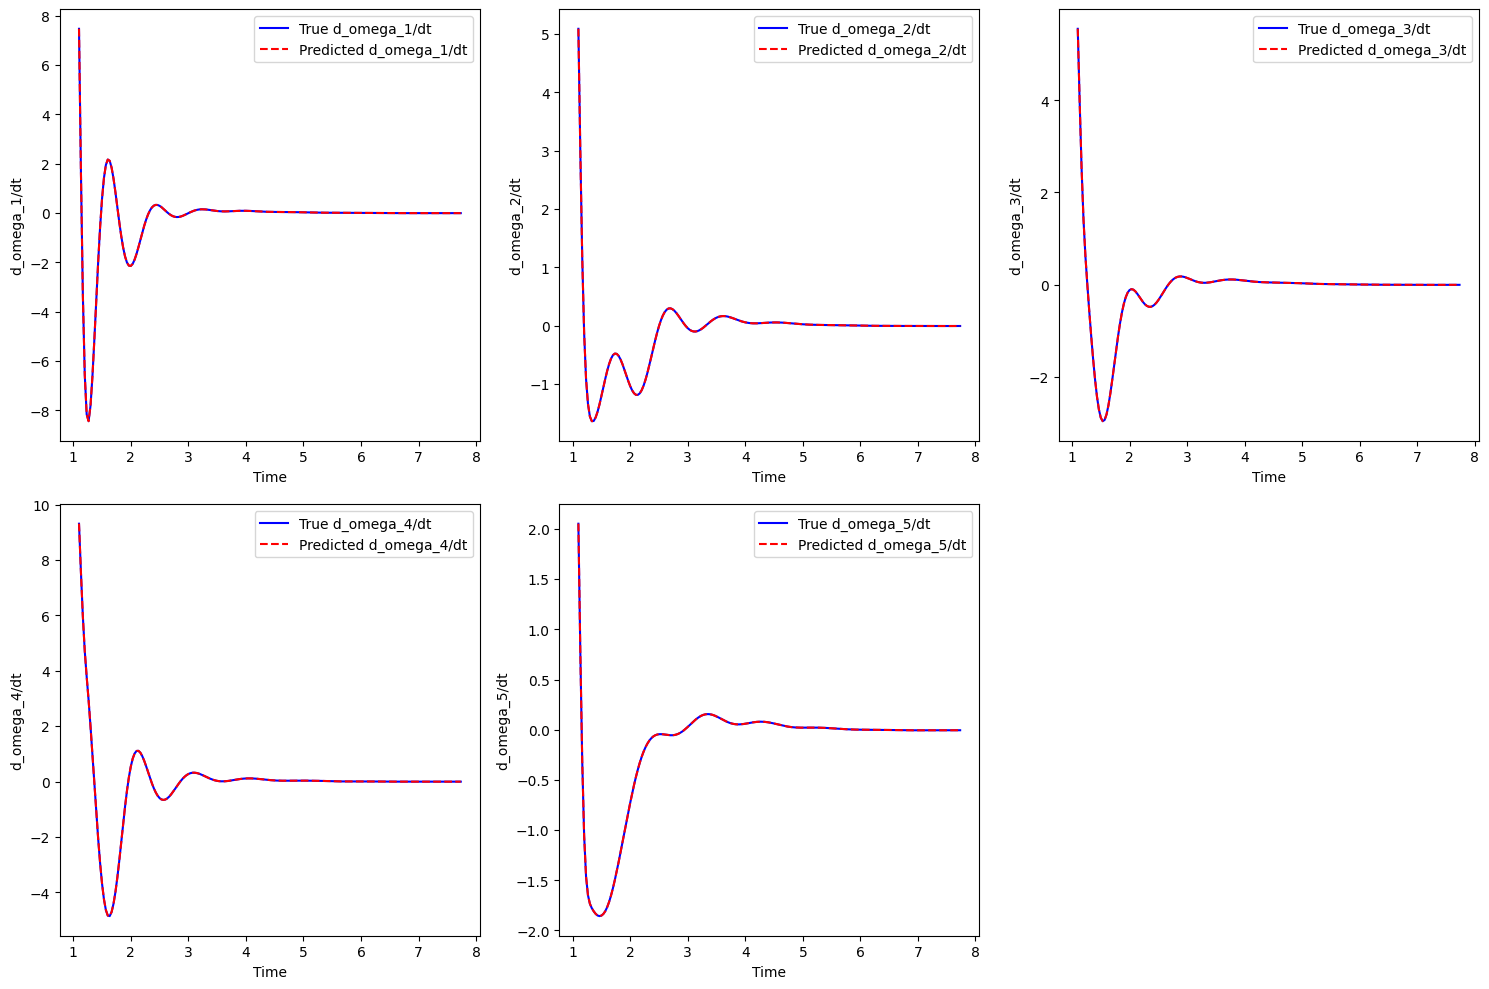


Discovered Equations:
(x0)' = 177926.182 1 + 158.314 x0 + -3306.149 x2 + -349.066 x3 + -1472.440 x4 + 53892.652 x5 + -114986.641 x6 + -524656.931 x7 + -10437.781 x8 + 861676.333 x9 + 65.680 x0^2 + 47.830 x0 x1 + -47.867 x0 x2 + -50.437 x0 x3 + -171.479 x0 x4 + 827.533 x0 x5 + 9.876 x0 x6 + -1740.903 x0 x7 + 2608.938 x0 x8 + -1979.055 x0 x9 + 209.443 x1 x2 + 186.918 x1 x3 + -643.064 x1 x4 + -182.149 x1 x5 + -647.166 x1 x6 + -1217.365 x1 x8 + 1599.870 x1 x9 + -887.313 x2^2 + 137.541 x2 x3 + 2828.364 x2 x4 + -559.616 x2 x5 + -1519.276 x2 x6 + 3966.466 x2 x7 + -7503.587 x2 x8 + 7356.172 x2 x9 + 67.600 x3^2 + -529.908 x3 x4 + 1296.892 x3 x5 + 1030.731 x3 x6 + -856.499 x3 x7 + 2975.984 x3 x8 + -4220.428 x3 x9 + 2074.617 x4^2 + 469.729 x4 x5 + 1620.614 x4 x6 + -2810.757 x4 x7 + 4002.204 x4 x8 + -3906.025 x4 x9 + -14707.039 x5^2 + -8675.659 x5 x6 + -56478.384 x5 x7 + 8299.322 x5 x8 + 48991.385 x5 x9 + 91953.531 x6^2 + 5364.894 x6 x7 + -20256.997 x6 x8 + 19589.836 x6 x9 + 288116.877 x7^2 + 951

In [6]:
# 评估和可视化
evaluate_and_visualize(model, train_x, time_train)